# Steps:


   - Split data into training and testing sets based on a specified 'split_condition'.
      - train = 1853 to 2000 
      - test = 2000 to till
      - X features tmin, af,rain,tavg
      - y feature tmax
   - Standardize feature variables using `StandardScaler`.

   - Create a dictionary containing various regression models.

   - Iterate through models, fit them on training data, and evaluate on test data.

 **RandomForest Hyperparameter Tuning:**
   - Define hyperparameter grid for RandomForestRegressor.
   - Perform randomized search using `RandomizedSearchCV`.


 ** ElasticNet Hyperparameter Tuning:**
   - Define hyperparameter grid for ElasticNet.
   - Perform randomized search using `RandomizedSearchCV`.

 **Lasso Hyperparameter Tuning:**
    - Define hyperparameter grid for Lasso.
    - Perform randomized search using `RandomizedSearchCV`.


 **Predictions and Results:**
    - Predict 'tmax' values using the best model and create a DataFrame of predictions and actual values.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge

import warnings
warnings.filterwarnings('ignore')

In [16]:
Data = pd.read_csv('Oxford_Data.csv')
Data

,yyyy,mm,tmax,tmin,af,rain,sun
0,NaN,NaN,degC,degC,days,mm,hours
1,1853.0,1.0,8.4,2.7,4,62.8,---
2,1853.0,2.0,3.2,-1.8,19,29.3,---
3,1853.0,3.0,7.7,-0.6,20,25.9,---
4,1853.0,4.0,12.6,4.5,0,60.1,---
...,...,...,...,...,...,...,...
2043,2023.0,3.0,10.6,4.5,3 1,4.9,65.9 Provisional
2044,2023.0,4.0,13.7,5.1,1,65.9,154.7 Provisional
2045,2023.0,5.0,18.3,* 8.4,0,51.2,221.5 Provisional
2046,2023.0,6.0,23.8,12.1,0,40.5,226.1 Provisional


In [17]:
# Remove columns sun'
columns_to_remove = ['sun']
Data = Data.drop(columns=columns_to_remove)

In [18]:
Data.dtypes    

yyyy    float64
mm      float64
tmax     object
tmin     object
af       object
rain     object
dtype: object

In [19]:
Data['yyyy'] = pd.to_numeric(Data['yyyy'], errors='coerce').astype('Int64')
Data['mm'] = pd.to_numeric(Data['mm'], errors='coerce').astype('Int64')
Data['tmax'] = pd.to_numeric(Data['tmax'], errors='coerce')
Data['tmin'] = pd.to_numeric(Data['tmin'], errors='coerce')
Data['af'] = pd.to_numeric(Data['af'], errors='coerce')
Data['rain'] = pd.to_numeric(Data['rain'], errors='coerce')    
Data.dtypes

yyyy      Int64
mm        Int64
tmax    float64
tmin    float64
af      float64
rain    float64
dtype: object

In [20]:
Data = Data.drop(index = Data.index[0])

In [21]:
Data.apply(pd.isnull).sum() # missing values

yyyy      0
mm        0
tmax      0
tmin     12
af      183
rain      0
dtype: int64

In [22]:
Data['tavg'] = (Data['tmax']+Data['tmin'])/2
Data

,yyyy,mm,tmax,tmin,af,rain,tavg
1,1853,1,8.4,2.7,4.0,62.8,5.55
2,1853,2,3.2,-1.8,19.0,29.3,0.70
3,1853,3,7.7,-0.6,20.0,25.9,3.55
4,1853,4,12.6,4.5,0.0,60.1,8.55
5,1853,5,16.8,6.1,0.0,59.5,11.45
...,...,...,...,...,...,...,...
2043,2023,3,10.6,4.5,NaN,4.9,7.55
2044,2023,4,13.7,5.1,1.0,65.9,9.40
2045,2023,5,18.3,NaN,0.0,51.2,NaN
2046,2023,6,23.8,12.1,0.0,40.5,17.95


# EDA

In [23]:
Data["tmin"].fillna( method ='ffill', inplace = True)
Data["af"].fillna( method ='ffill', inplace = True)
Data["tavg"].fillna( method ='ffill', inplace = True)
Data.apply(pd.isnull).sum() # missing values

yyyy    0
mm      0
tmax    0
tmin    0
af      0
rain    0
tavg    0
dtype: int64

In [24]:
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 1 to 2047
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yyyy    2047 non-null   Int64  
 1   mm      2047 non-null   Int64  
 2   tmax    2047 non-null   float64
 3   tmin    2047 non-null   float64
 4   af      2047 non-null   float64
 5   rain    2047 non-null   float64
 6   tavg    2047 non-null   float64
dtypes: Int64(2), float64(5)
memory usage: 116.1 KB
None


In [25]:
print(Data.describe())

              yyyy           mm         tmax         tmin           af  \
count  2047.000000  2047.000000  2047.000000  2047.000000  2047.000000   
mean   1937.792379     6.491451    13.981583     6.230093     3.763068   
std      49.255586     3.452060     5.700771     4.213745     5.353217   
min    1853.000000     1.000000    -0.200000    -5.800000     0.000000   
25%    1895.000000     3.000000     9.000000     2.800000     0.000000   
50%    1938.000000     6.000000    13.800000     5.600000     1.000000   
75%    1980.000000     9.000000    19.100000    10.200000     6.000000   
max    2023.000000    12.000000    27.400000    15.700000    28.000000   

              rain         tavg  
count  2047.000000  2047.000000  
mean     46.154763    10.102296  
std      24.957228     4.909663  
min       0.000000    -3.000000  
25%      26.100000     6.000000  
50%      44.200000     9.700000  
75%      64.250000    14.650000  
max      99.900000    21.100000  


# split data

In [26]:

X = Data.drop(columns=['tmax','yyyy','mm'])
y = Data['tmax']

In [27]:
print("Feature Variables (X):")
print(X.head())

Feature Variables (X):
   tmin    af  rain   tavg
1   2.7   4.0  62.8   5.55
2  -1.8  19.0  29.3   0.70
3  -0.6  20.0  25.9   3.55
4   4.5   0.0  60.1   8.55
5   6.1   0.0  59.5  11.45


In [28]:
y.head()

1     8.4
2     3.2
3     7.7
4    12.6
5    16.8
Name: tmax, dtype: float64

In [29]:
# Define the splitting condition 
split_condition = 2000

# Select the rows where the 'yyyy' column meets the condition for training
X_train = X[Data['yyyy'] <= split_condition]
y_train = y[Data['yyyy']<= split_condition]

# For test data, select the rows where the 'yyyy' column is greater than 2000
X_test = X[Data['yyyy'] > split_condition]
y_test = y[Data['yyyy']> split_condition]

In [30]:
# Print sample data from both sets
print("Train Data:")
print(X_train)

print("\nTest Data:")
print(X_test)

Train Data:
      tmin    af  rain   tavg
1      2.7   4.0  62.8   5.55
2     -1.8  19.0  29.3   0.70
3     -0.6  20.0  25.9   3.55
4      4.5   0.0  60.1   8.55
5      6.1   0.0  59.5  11.45
...    ...   ...   ...    ...
1772  13.3   0.0  58.3  18.00
1773  12.1   0.0  87.2  15.65
1774   8.2   0.0  19.5  11.25
1775   4.8   0.0  99.1   7.70
1776   4.2   7.0  99.8   6.40

[1776 rows x 4 columns]

Test Data:
      tmin    af  rain   tavg
1777   1.2  13.0  57.4   3.80
1778   2.0  10.0  68.6   5.40
1779   3.1   5.0  75.1   6.05
1780   4.8   0.0  72.7   8.85
1781   7.9   0.0  35.5  13.20
...    ...   ...   ...    ...
2043   4.5   9.0   4.9   7.55
2044   5.1   1.0  65.9   9.40
2045   5.1   0.0  51.2   9.40
2046  12.1   0.0  40.5  17.95
2047  12.1   0.0  99.9  17.95

[271 rows x 4 columns]


In [31]:
# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1776, 4)
X_test shape: (271, 4)
y_train shape: (1776,)
y_test shape: (271,)


In [32]:
pip install pandas numpy statsmodels matplotlib

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Define the models
models = {
    'RF Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'ElasticNet': ElasticNet(),
    'GBoost Regressor': GradientBoostingRegressor(),
    'SVR': SVR(),
    'CatBoost Regressor': CatBoostRegressor(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
}

# You can proceed with fitting and evaluating these models using your data

model_r2_score = {}  # Initialize an empty dictionary to store R-squared scores

for model_name, model in models.items():
    model.fit(X_train, y_train)
    model_r2_score[model_name] = model.score(X_test, y_test)

NameError: name 'Ridge' is not defined

In [ ]:
model_comparison = pd.DataFrame({'model': model_r2_score.keys(), 'R-squared': model_r2_score.values()})
print(model_comparison)

# Random Forest Regressor

In [34]:
# Define the hyperparameter grid for random search
rf_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestRegressor
rs_rf = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions=rf_grid,
    cv=5,
    n_iter=20,
    verbose=True
)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [36]:
rs_rf.best_params_

{'n_estimators': 310,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': None}

In [37]:
# Evaluate the randomized search random forest model
rs_rf.score(X_test, y_test)

0.9789113173863612

# LinearRegression

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid for random search
lr_grid = {
    "fit_intercept": [True, False],
    "normalize": [True, False],
    "copy_X": [True, False]
}

# Set random seed for reproducibility
np.random.seed(42)

# Setup random hyperparameter search for LinearRegression
rs_lr = RandomizedSearchCV(
    LinearRegression(),           # Create an instance of LinearRegression
    param_distributions=lr_grid,  # Use the defined hyperparameter grid
    cv=5,                         # Number of cross-validation folds
    n_iter=20,                    # Number of iterations in the search
    verbose=True                 # Print progress during search
)

# Fit the random hyperparameter search model to training data
rs_lr.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


RandomizedSearchCV(cv=5, estimator=LinearRegression(), n_iter=20,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'normalize': [True, False]},
                   verbose=True)

In [39]:
# Evaluate the randomized search random forest model
rs_lr.best_params_

{'normalize': True, 'fit_intercept': False, 'copy_X': True}

In [40]:
# Evaluate the randomized search random forest model
rs_lr.score(X_test, y_test)

0.9824359766930927

# Best model = RandomForestRegressor

In [41]:
from sklearn.metrics import mean_squared_error
best_lr_model = rs_lr.best_estimator_

# Predict using the best model
y_pred_best_lr_model = best_lr_model.predict(X_test)

# Calculate additional metrics
mse_best_model = mean_squared_error(y_test, y_pred_best_lr_model)
rmse_best_model = np.sqrt(mse_best_model)
r2_best_model = best_lr_model.score(X_test, y_test)

In [42]:
print("Best Model Metrics:")
print("Mean Squared Error:", mse_best_model)
print("Root Mean Squared Error:", rmse_best_model)
print("R-squared:", r2_best_model)

Best Model Metrics:
Mean Squared Error: 0.5574110075706619
Root Mean Squared Error: 0.7465996300365155
R-squared: 0.9824359766930927


In [43]:
y_pred = rs_lr.predict(X_test)
print(y_pred)

num_predictions = len(y_pred)
print("Number of Predictions:", num_predictions)

[ 6.3988132   8.79613781  8.99472711 12.89288001 18.49784114 20.70186986
 23.40137129 22.69773484 17.90225982 16.99831004 11.19810381  6.80156341
  9.19674009 11.09492968 12.39803813 15.19492903 16.79747522 20.00000358
 22.09692856 22.80133348 19.70137828 14.80126862 11.79971037  8.8936867
  7.59581179  8.40142817 13.29768155 15.29690493 17.4975571  22.39965625
 23.70151332 25.50538605 21.29819013 13.9970786  11.99368732  8.69569053
  8.79697888  8.70212597 10.89483001 14.69433814 17.99869154 21.80331087
 21.99790971 23.40469958 20.10337852 14.70156996 10.89971959  8.59850356
  9.39950818  7.30176701 11.19924879 14.29603327 17.19852871 21.59686785
 22.30412842 23.10213891 20.90230612 17.10161873  9.90048554  7.69869388
  7.20135057  6.59990159  9.19677659 13.89759409 17.60392998 23.10381823
 27.09864751 21.80171885 22.09913146 17.2044336  12.09442946  9.39742076
 10.39621305  9.69563159 11.9960434  17.79788377 17.49722932 20.49781818
 20.60605918 21.70201272 19.20280845 15.09671551 11.

In [48]:
result_df = pd.DataFrame({
    'yyyy': Data.loc[X_test.index, 'yyyy'],  # Get the 'yyyy' values corresponding to the test data
    'mm': Data.loc[X_test.index, 'mm'],      # Get the 'mm' values corresponding to the test data
    'tmax': y_test,                          # Original 'tmax' values from the test data
    'predicted_tmax': y_pred        # Predicted 'tmax' values
})

# Print the resulting DataFrame
print(result_df)

      yyyy  mm  tmax  predicted_tmax
1777  2001   1   6.4        6.398813
1778  2001   2   8.8        8.796138
1779  2001   3   9.0        8.994727
1780  2001   4  12.9       12.892880
1781  2001   5  18.5       18.497841
...    ...  ..   ...             ...
2043  2023   3  10.6       10.604457
2044  2023   4  13.7       13.693984
2045  2023   5  18.3       13.694894
2046  2023   6  23.8       23.800701
2047  2023   7  21.5       23.795100

[271 rows x 4 columns]


In [52]:
len(Data['yyyy'])

2047

# Visualize predicted vs. actual values

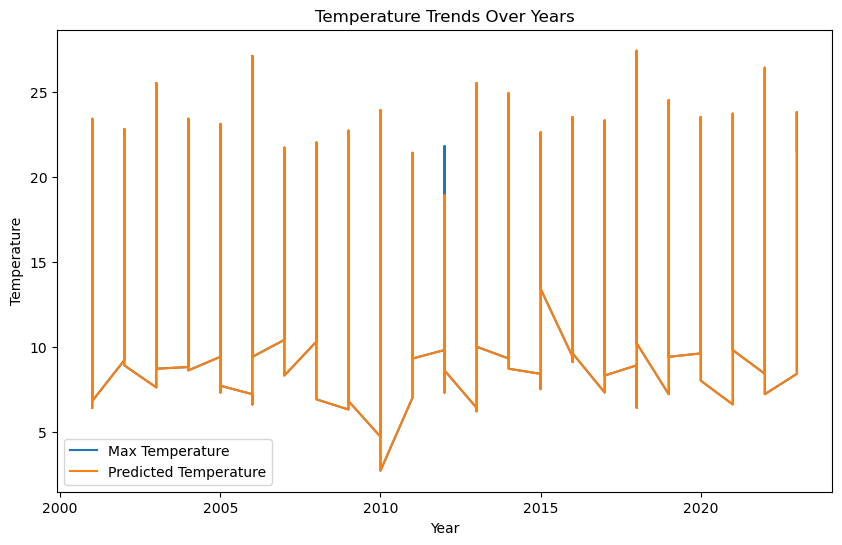

In [54]:
# Plotting temperature data over months
plt.style.use('default')
plt.figure(figsize=(10, 6))

plt.plot(Data.loc[X_test.index, 'yyyy'], y_test, label='Max Temperature')
plt.plot(Data.loc[X_test.index, 'yyyy'], y_pred, label='Predicted Temperature')  # Corrected line

plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Years')
plt.legend()

plt.show()